In [1]:
# %% Cell 0: Generar automáticamente el archivo README.tex (y compilar opcionalmente)

import subprocess

# Contenido LaTeX para el README
latex_content = r"""\documentclass[a4paper,11pt]{article}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{lmodern}
\usepackage{hyperref}
\usepackage{geometry}
\geometry{margin=2.5cm}

\title{Simulación del Modelo de Ising}
\author{Tu Nombre}
\date{\today}

\begin{document}

\maketitle

\begin{abstract}
Este documento acompaña al notebook de Jupyter que implementa una simulación de Monte Carlo del modelo de Ising en una red bidimensional de tamaño \(N \times N\). Calcula métricas como energía, magnetización, capacidad calorífica, susceptibilidad y tiempo de correlación integrado.
\end{abstract}

\section*{Parámetros de la simulación}
\begin{itemize}
  \item \textbf{N}: tamaño de la red (número de espines por dimensión).
  \item \textbf{T}: temperatura del sistema.
  \item \textbf{J}: constante de interacción entre espines.
  \item \texttt{MC\_STEPS}: número de pasos Monte Carlo.
  \item \texttt{SAVE\_INTERVAL}: intervalo de guardado de snapshots.
  \item \texttt{SEED}: semilla para reproducibilidad.
\end{itemize}

\section*{Instalación de dependencias}
Para ejecutar el notebook en Jupyter, instala las librerías necesarias así:
\begin{verbatim}
%pip install numpy numba tqdm scipy matplotlib imageio
\end{verbatim}

\section*{Estructura del Notebook}
\begin{enumerate}
  \item \textbf{Celda 1:} Importaciones y parseo de argumentos.
  \item \textbf{Celda 2:} Parámetros, semilla y configuración de Numba.
  \item \textbf{Celda 3:} Funciones principales (\texttt{compute\_flip\_probs}, \texttt{mc\_sweep}, versiones vectorizadas).
  \item \textbf{Celda 4:} Simulación con \texttt{tqdm}, checkpointing y métricas.
  \item \textbf{Celda 5:} Post-procesado y guardado de datos.
  \item \textbf{Celda 6:} Plot de métricas.
  \item \textbf{Celda 7:} Animación a MP4 y GIF.
\end{enumerate}

\end{document}
"""

# Escribir el archivo .tex
with open("README.tex", "w", encoding="utf-8") as f:
    f.write(latex_content)
print("✅ Archivo README.tex generado.")

# Opcional: compilar con pdflatex (requiere pdflatex instalado)
try:
    subprocess.run(["pdflatex", "README.tex"], check=True, stdout=subprocess.DEVNULL)
    print("✅ README.pdf generado con pdflatex.")
except FileNotFoundError:
    print("⚠️ pdflatex no está instalado o no está en el PATH. Solo se ha escrito README.tex.")
except subprocess.CalledProcessError as e:
    print(f"❌ Error durante la compilación: {e}")


✅ Archivo README.tex generado.
✅ README.pdf generado con pdflatex.


In [26]:
# %% Cell 1: Imports, parseo de args, logging y perfilador
import os, sys, time
import logging
import cProfile
import pstats
import numba; from numba import njit, prange
import numpy as np
from tqdm import tqdm
import argparse
from scipy.signal import convolve2d
import io, imageio 
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import random

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger()

TamañoRed = 250 # Tamaño de la red (N x N)
Temperatura = 2/(np.log(1 + 2**0.5)) # Temperatura del sistema
CteIntEspin = 1.0 # Constante de interacción entre espines
PasosMontecarlo = 1000 # Número de pasos Monte Carlo
IntervaloGuardado = 1 # Intervalo de guardado de snapshots
SemillaReproducible = random.randrange(100) # Semilla para reproducibilidad

def parse_args():
    parser = argparse.ArgumentParser("Ising MC")
    parser.add_argument("-N", type=int, default=TamañoRed, dest="N")
    parser.add_argument("-T", type=float, default=Temperatura, dest="T")
    parser.add_argument("-J", type=float, default=CteIntEspin, dest="J")
    parser.add_argument("--steps",  type=int, default=PasosMontecarlo, dest="MC_STEPS")
    parser.add_argument("--save-interval", type=int, default=IntervaloGuardado, dest="SAVE_INTERVAL")
    parser.add_argument("--seed", type=int, default=SemillaReproducible, dest="seed")
    return parser.parse_args(args=[])

args = parse_args()


In [27]:
# %% Cell 2: Parámetros y semilla
N, T, J = args.N, args.T, args.J
MC_STEPS, SAVE_INTERVAL, SEED = args.MC_STEPS, args.SAVE_INTERVAL, args.seed

# Hilos y semilla
n_threads = max(1, int(os.cpu_count()*0.8))
numba.set_num_threads(n_threads)
print(f"Threads: {n_threads}/{os.cpu_count()}, seed={SEED}")

np.random.seed(SEED)


Threads: 12/16, seed=89


In [28]:
# %% Cell 3: Funciones de flip‐probs, mc_sweep y versiones vectorizadas
energy_changes = np.array([-8, -4, 0, 4, 8], np.int8)

def compute_flip_probs(T):
    return np.exp(-energy_changes.astype(np.float64) / T)

@njit(parallel=True, fastmath=True)
def mc_sweep(spins, N, w, rand_mat):
    accepted_per_i = np.zeros(N, np.int64)
    for i in prange(N):
        acc_i = 0
        for j in range(N):
            vecinos = (
                spins[(i + 1) % N, j] + spins[(i - 1) % N, j] +
                spins[i, (j + 1) % N] + spins[i, (j - 1) % N]
            )
            delta_E = 2 * spins[i, j] * vecinos
            idx     = delta_E // 4 + 2
            if delta_E <= 0 or rand_mat[i, j] < w[idx]:
                spins[i, j] = -spins[i, j]
                acc_i += 1
        accepted_per_i[i] = acc_i
    return spins, accepted_per_i.sum()

# Kernel de vecinos 4-conectividad
kernel = np.array([[0,1,0],
                   [1,0,1],
                   [0,1,0]], dtype=np.int8)

def compute_neighbor_sum(spins):
    return convolve2d(spins, kernel, mode='same', boundary='wrap')

def compute_energy_vec(spins, J):
    neigh = compute_neighbor_sum(spins)
    # Cada par contado dos veces, por eso /2
    return -J * np.sum(spins * neigh) / 2

def compute_magnetization_vec(spins):
    return spins.mean()


In [29]:
# %% Cell 4: Simulación principal (usando versiones vectorizadas para métricas)
# Inicialización
spins = np.random.choice(np.int8([-1, 1]), size=(N, N))
w     = compute_flip_probs(T)

# Prueba de compilación de mc_sweep
_ = mc_sweep(spins.copy(), N, w, np.random.rand(N, N))[0]

# Arrays
magnetizations   = np.zeros(MC_STEPS)
energies         = np.zeros(MC_STEPS)
acceptance_rates = np.zeros(MC_STEPS)
snapshots        = []

for step in tqdm(range(MC_STEPS), desc="MC sweeps"):
    rnd = np.random.rand(N, N)
    spins, acc = mc_sweep(spins, N, w, rnd)
    acceptance_rates[step] = acc / (N * N)
    # aquí usamos las funciones vectorizadas
    magnetizations[step]   = compute_magnetization_vec(spins)
    energies[step]         = compute_energy_vec(spins, J)
    if step % SAVE_INTERVAL == 0:
        snapshots.append(spins.copy())


MC sweeps: 100%|██████████| 1000/1000 [00:03<00:00, 286.87it/s]


In [30]:
# %% Cell 5: Post-procesado, DataFrame y guardado con barra de progreso
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

# Lista de pasos de post-procesado
tasks = [
    'metrics',     # cálculo de calor y susceptibilidad
    'acf',         # autocorrelación y τ_int
    'create_df',   # creación DataFrame
    'save_csv',    # guardado CSV
    'save_pickle', # guardado pickle
    'save_npz'     # guardado NPZ
]

start_time = time.time()
for idx, task in enumerate(tqdm(tasks, desc="Post-procesado", unit="step")):
    if task == 'metrics':
        mean_E, mean_E2    = energies.mean(), (energies**2).mean()
        heat_capacity      = (mean_E2 - mean_E**2) / (T**2 * N**2)
        mean_m, mean_m2    = magnetizations.mean(), (magnetizations**2).mean()
        susceptibility     = N**2 * (mean_m2 - mean_m**2) / T

    elif task == 'acf':
        mag      = magnetizations - mean_m
        acf_full = np.correlate(mag, mag, mode='full')
        acf      = acf_full[MC_STEPS - 1:] / acf_full[MC_STEPS - 1]
        tau_int  = 1 + 2 * np.sum(acf[1:])

    elif task == 'create_df':
        df = pd.DataFrame({
            'step': np.arange(MC_STEPS),
            'magnetization': magnetizations,
            'energy': energies,
            'acceptance': acceptance_rates
        })

    elif task == 'save_csv':
        df.to_csv('ising_metrics.csv', index=False)

    elif task == 'save_pickle':
        df.to_pickle('ising_metrics.pkl')

    elif task == 'save_npz':
        snap_arr = np.array(snapshots, dtype=np.int8)
        np.savez_compressed(
            "ising_data.npz",
            snapshots=snap_arr,
            magnetization=magnetizations,
            energy=energies,
            acceptance=acceptance_rates,
            heat_capacity=heat_capacity,
            susceptibility=susceptibility,
            autocorrelation=acf,
            tau_int=tau_int
        )

# Resumen final con tiempo total
elapsed = time.time() - start_time
h, rem = divmod(elapsed, 3600)
m, s   = divmod(rem, 60)
print(
    f"\nPost-procesado completado en {int(h):02d}:{int(m):02d}:{int(s):02d}\n"
    f"Heat capacity per spin:  {heat_capacity:.6f}\n"
    f"Susceptibility:          {susceptibility:.6f}\n"
    f"Integrated corr. time τ: {tau_int:.2f} pasos"
)


Post-procesado: 100%|██████████| 6/6 [00:05<00:00,  1.13step/s]


Post-procesado completado en 00:00:05
Heat capacity per spin:  23.386484
Susceptibility:          153.200437
Integrated corr. time τ: 0.00 pasos


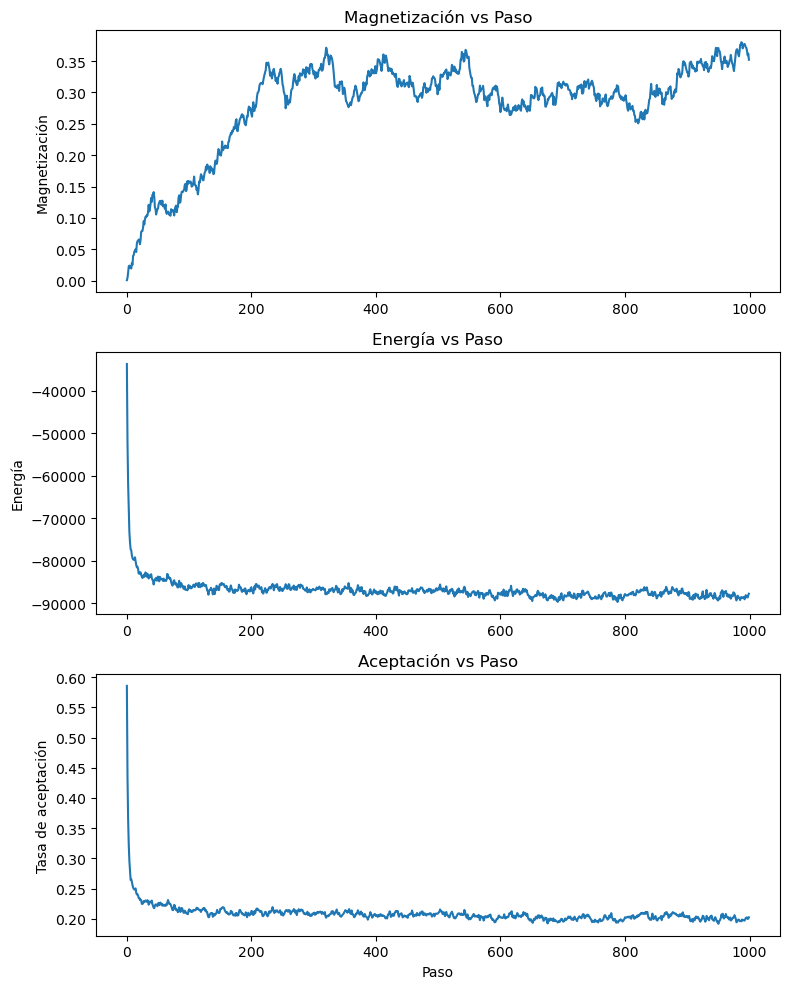

In [31]:
# %% Cell 6: Plot de métricas tras simulación
import matplotlib.pyplot as plt

# Eje de pasos
steps = np.arange(MC_STEPS)

# Crear figura con 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Magnetización vs paso
axs[0].plot(steps, magnetizations)
axs[0].set_ylabel('Magnetización')
axs[0].set_title('Magnetización vs Paso')

# Energía vs paso
axs[1].plot(steps, energies)
axs[1].set_ylabel('Energía')
axs[1].set_title('Energía vs Paso')

# Tasa de aceptación vs paso
axs[2].plot(steps, acceptance_rates)
axs[2].set_ylabel('Tasa de aceptación')
axs[2].set_xlabel('Paso')
axs[2].set_title('Aceptación vs Paso')

plt.tight_layout()
plt.show()


In [32]:
# %% Celda: escala manual o automática + barras + NVENC
import subprocess, threading, re, math
import numpy as np
from tqdm.auto import tqdm

# ── Parámetros de usuario ─────────────────────────────────────────────────────
FILE_IN   = "ising_data.npz"
FILE_OUT  = "ising"
INTERVAL  = 50          # ms → fps
GPU_ID    = 0           # 0 = RTX principal
TARGET_W  = 640         # ← pon aquí el ancho deseado o None
TARGET_H  = None        # ← pon aquí la altura deseada o None
MIN_SIDE  = 160         # mínimo seguro para NVENC (≥ 145 y par)
# ──────────────────────────────────────────────────────────────────────────────

# 1) Cargar datos --------------------------------------------------------------
data = np.load(FILE_IN)
frames_data = data["snapshots"]
nframes, h0, w0 = frames_data.shape
fps = 1000 / INTERVAL
print(f"    → {nframes} frames ({w0}×{h0}px)  @ {fps:.1f} fps")

# 2) Calcular resolución de salida --------------------------------------------
w_out, h_out = w0, h0

if TARGET_W is not None and TARGET_H is None:
    scale = TARGET_W / w0
    w_out = TARGET_W
    h_out = int(round(h0 * scale))
elif TARGET_H is not None and TARGET_W is None:
    scale = TARGET_H / h0
    h_out = TARGET_H
    w_out = int(round(w0 * scale))
elif TARGET_W is not None and TARGET_H is not None:
    # ambos dados: se fuerza exactamente lo indicado (podría distorsionar)
    w_out, h_out = TARGET_W, TARGET_H

# asegurar mínimo NVENC
if w_out < MIN_SIDE or h_out < MIN_SIDE:
    factor = math.ceil(MIN_SIDE / min(w_out, h_out))
    w_out *= factor
    h_out *= factor
    print(f"⚠️  Redimensionado extra para cumplir mínimo NVENC ({MIN_SIDE}px)")

# redondear a par
w_out = (w_out // 2) * 2
h_out = (h_out // 2) * 2

if (w_out, h_out) != (w0, h0):
    print(f"🔧  Escalando: {w0}×{h0}  →  {w_out}×{h_out}")

vf_filter = ["-vf", f"scale={w_out}:{h_out}:flags=neighbor"] \
            if (w_out, h_out) != (w0, h0) else []

# 3) Detectar NVENC ------------------------------------------------------------
encoders = subprocess.run(["ffmpeg", "-hide_banner", "-encoders"],
                          capture_output=True, text=True).stdout
if "h264_nvenc" in encoders:
    print("✅  h264_nvenc detectado → GPU.")
    video_opts = ["-c:v", "h264_nvenc", "-gpu", str(GPU_ID),
                  "-preset", "lossless", "-profile:v", "high444p",
                  "-pix_fmt", "yuv444p"]
else:
    print("⚠️  NVENC no disponible → libx264 (CPU).")
    video_opts = ["-c:v", "libx264", "-preset", "veryslow", "-crf", "0",
                  "-pix_fmt", "yuv420p"]

# 4) Comando FFmpeg ------------------------------------------------------------
cmd = ["ffmpeg", "-y",
       "-f", "rawvideo", "-pix_fmt", "rgb24",
       "-s", f"{w0}x{h0}", "-r", str(fps), "-i", "-",
       "-progress", "pipe:1", "-loglevel", "error"] \
      + vf_filter + video_opts + [f"{FILE_OUT}.mp4"]
print("FFmpeg:", " ".join(cmd))

# 5) Lanzar FFmpeg -------------------------------------------------------------
proc = subprocess.Popen(cmd, stdin=subprocess.PIPE,
                        stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                        bufsize=0)

# 6) Barra de codificación -----------------------------------------------------
pbar_enc = tqdm(total=nframes, desc="🛠️ Codificando", unit="frame")
def _watch():
    re_time = re.compile(rb"out_time_ms=(\d+)")
    re_fr   = re.compile(rb"frame=(\d+)")
    while True:
        raw = proc.stdout.readline()
        if not raw:
            break
        m = re_fr.search(raw) or re_time.search(raw)
        if m:
            val = int(m.group(1))
            done = val if b"frame" in raw else min(nframes, int(round(val*fps/1000)))
            pbar_enc.n = done
            pbar_enc.refresh()
threading.Thread(target=_watch, daemon=True).start()

# 7) Enviar frames -------------------------------------------------------------
with tqdm(total=nframes, desc="📤 Enviando frames", unit="frame") as pbar_in:
    for frame in frames_data:
        rgb = np.repeat(((frame + 1) * 127.5).astype(np.uint8)[..., None], 3, -1)
        proc.stdin.write(rgb.tobytes())
        pbar_in.update(1)
proc.stdin.close(); proc.wait()

pbar_enc.n = nframes; pbar_enc.refresh(); pbar_enc.close()
print("🎉  Vídeo generado:", f"{FILE_OUT}.mp4  ({w_out}×{h_out})")


    → 1000 frames (250×250px)  @ 20.0 fps
🔧  Escalando: 250×250  →  640×640
✅  h264_nvenc detectado → GPU.
FFmpeg: ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 250x250 -r 20.0 -i - -progress pipe:1 -loglevel error -vf scale=640:640:flags=neighbor -c:v h264_nvenc -gpu 0 -preset lossless -profile:v high444p -pix_fmt yuv444p ising.mp4


🛠️ Codificando: 100%|██████████| 1000/1000 [00:02<00:00, 386.24frame/s]

🎉  Vídeo generado: ising.mp4  (640×640)
